In [ ]:
#pip install tqdm

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [2]:
REBUILD_DATA = False

class Currency():
    IMG_SIZE = 150
    BACK = "C:/Users/Aayush/Desktop/Fake-Currency-Detection/Images/back"
    FRONT = "C:/Users/Aayush/Desktop/Fake-Currency-Detection/Images/front"
    LABELS = {BACK: 0, FRONT: 1}
    training_data = []
    backcount = 0
    frontcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label,f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])


                    if label == self.FRONT:
                        self.frontcount += 1
                    elif label == self.BACK:
                        self.backcount += 1
                except Exception as e:
                    pass
                    #print(str(e))
        
        
            
        np.random.shuffle(self.training_data)
        np.save("training_data.npy",self.training_data)
        print('Front:', self.frontcount)
        print('Back:', self.backcount)
    
if  REBUILD_DATA:
    currency = Currency()
    currency.make_training_data()
                           

In [3]:
training_data = np.load("training_data.npy", allow_pickle=True)


In [4]:
print(len(training_data))

698


In [5]:
print(training_data[1])

[array([[255, 255, 255, ..., 217, 224, 217],
       [255, 255, 255, ...,  50,  53,  52],
       [255, 255, 255, ..., 176, 175, 176],
       ...,
       [255, 255, 255, ..., 196, 197, 196],
       [255, 255, 255, ..., 195, 197, 195],
       [255, 255, 255, ..., 198, 196, 195]], dtype=uint8)
 array([1., 0.])]


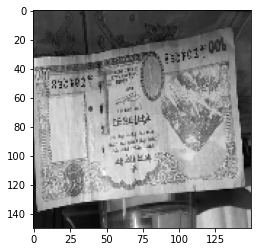

In [6]:
import matplotlib.pyplot as plt

plt.imshow(training_data[10][0], cmap="gray")
plt.show()

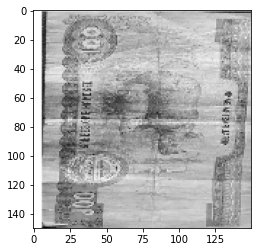

In [7]:
plt.imshow(training_data[1][0], cmap="gray")
plt.show()

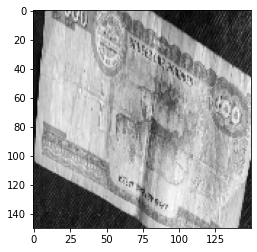

In [8]:
plt.imshow(training_data[5][0], cmap="gray")
plt.show()

# TRAINNING THE CNN

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #Make Layers (i/p, o/p, kernel_size (5*5 window))
        #euta layer ko o/p arko layer lai i/p
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        #self.conv4 = nn.Conv2d(128, 256, 5)
        #self.conv5 = nn.Conv2d(256, 512, 5)
        ##NN needs to have at least 1 or 2 linear layer
        
        x = torch.randn(150,150).view(-1,1,150,150)
        self._to_linear = None
        self.convs(x)
        print("self==",self._to_linear)        
        
        #fully-connected layer fcl i/p is the o/p from final pooling or Convolution Layer, which is
        #flattened and then feeded into fcl. 
        self.fc1 = nn.Linear(self._to_linear, 512) #yo o/p arko layer lai i/p
        self.fc2 = nn.Linear(512, 2) #512 i/p and 2 classes -front/back
        
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        
        
        print(x[0].shape)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

net = Net()
print(net)

torch.Size([128, 15, 15])
self== 28800
Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [13]:
import torch.optim as optim

In [16]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 150, 150)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

#Separate training and validation set
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)
print("X =", X)

69
X = tensor([[[0.7137, 0.6118, 0.6000,  ..., 0.1765, 0.1843, 0.2000],
         [0.6627, 0.6431, 0.5961,  ..., 0.1490, 0.1804, 0.1176],
         [0.6627, 0.6314, 0.6118,  ..., 0.1922, 0.1647, 0.1412],
         ...,
         [0.3059, 0.2627, 0.2471,  ..., 0.6510, 0.6941, 0.6941],
         [0.4078, 0.2471, 0.4275,  ..., 0.6706, 0.7059, 0.7843],
         [0.2510, 0.4392, 0.3333,  ..., 0.7059, 0.7373, 0.7137]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.8510, 0.8784, 0.8510],
         [1.0000, 1.0000, 1.0000,  ..., 0.1961, 0.2078, 0.2039],
         [1.0000, 1.0000, 1.0000,  ..., 0.6902, 0.6863, 0.6902],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.7686, 0.7725, 0.7686],
         [1.0000, 1.0000, 1.0000,  ..., 0.7647, 0.7725, 0.7647],
         [1.0000, 1.0000, 1.0000,  ..., 0.7765, 0.7686, 0.7647]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0

In [17]:
X.dtype

torch.float32

In [18]:
X.shape

torch.Size([698, 150, 150])

In [19]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

629
69


In [21]:
BATCH_SIZE = 64
#Easiest way to solve hidden memory error is change batch size
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        #print(i, i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,150,150)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        #optimization
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
print(loss)
        

  0%|                                                   | 0/10 [00:00<?, ?it/s]

torch.Size([128, 15, 15])


 10%|████▏                                     | 1/10 [02:42<24:25, 162.79s/it]

torch.Size([128, 15, 15])


 20%|████████▍                                 | 2/10 [04:30<19:30, 146.36s/it]

torch.Size([128, 15, 15])


 30%|████████████▌                             | 3/10 [06:22<15:51, 135.88s/it]

torch.Size([128, 15, 15])


 40%|████████████████▊                         | 4/10 [08:20<13:03, 130.65s/it]

torch.Size([128, 15, 15])


 50%|█████████████████████                     | 5/10 [10:22<10:39, 127.96s/it]

torch.Size([128, 15, 15])


 60%|█████████████████████████▏                | 6/10 [13:25<09:37, 144.48s/it]

torch.Size([128, 15, 15])


 70%|█████████████████████████████▍            | 7/10 [15:29<06:54, 138.29s/it]

torch.Size([128, 15, 15])


 80%|█████████████████████████████████▌        | 8/10 [17:29<04:26, 133.02s/it]

torch.Size([128, 15, 15])


 90%|█████████████████████████████████████▊    | 9/10 [19:32<02:09, 129.92s/it]

torch.Size([128, 15, 15])


100%|█████████████████████████████████████████| 10/10 [21:16<00:00, 127.65s/it]


tensor(0.2461, grad_fn=<MseLossBackward>)


print(i, i+BATCH_SIZE)  ->
These are the slices to the actual training data. first batch is 0-100 index. NExt 100-200 and so in to the entire dataset.


In [22]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 150, 150))[0]
        #print(real_class, net_out)
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy:", round(correct/total, 3))
    

  0%|                                                   | 0/69 [00:00<?, ?it/s]

torch.Size([128, 15, 15])


  3%|█▏                                         | 2/69 [00:01<01:14,  1.12s/it]

torch.Size([128, 15, 15])


  4%|█▊                                         | 3/69 [00:02<01:01,  1.07it/s]

torch.Size([128, 15, 15])


  6%|██▍                                        | 4/69 [00:02<00:53,  1.22it/s]

torch.Size([128, 15, 15])


  7%|███                                        | 5/69 [00:03<00:47,  1.34it/s]

torch.Size([128, 15, 15])


  9%|███▋                                       | 6/69 [00:04<00:43,  1.45it/s]

torch.Size([128, 15, 15])


 10%|████▎                                      | 7/69 [00:04<00:38,  1.60it/s]

torch.Size([128, 15, 15])


 12%|████▉                                      | 8/69 [00:05<00:35,  1.73it/s]

torch.Size([128, 15, 15])


 13%|█████▌                                     | 9/69 [00:05<00:32,  1.84it/s]

torch.Size([128, 15, 15])


 14%|██████                                    | 10/69 [00:05<00:30,  1.93it/s]

torch.Size([128, 15, 15])


 16%|██████▋                                   | 11/69 [00:06<00:28,  2.00it/s]

torch.Size([128, 15, 15])


 17%|███████▎                                  | 12/69 [00:06<00:28,  1.98it/s]

torch.Size([128, 15, 15])


 19%|███████▉                                  | 13/69 [00:07<00:29,  1.88it/s]

torch.Size([128, 15, 15])


 20%|████████▌                                 | 14/69 [00:08<00:29,  1.88it/s]

torch.Size([128, 15, 15])


 22%|█████████▏                                | 15/69 [00:08<00:29,  1.85it/s]

torch.Size([128, 15, 15])


 23%|█████████▋                                | 16/69 [00:09<00:28,  1.85it/s]

torch.Size([128, 15, 15])


 25%|██████████▎                               | 17/69 [00:09<00:28,  1.83it/s]

torch.Size([128, 15, 15])


 26%|██████████▉                               | 18/69 [00:10<00:28,  1.78it/s]

torch.Size([128, 15, 15])


 28%|███████████▌                              | 19/69 [00:10<00:29,  1.72it/s]

torch.Size([128, 15, 15])


 29%|████████████▏                             | 20/69 [00:11<00:28,  1.70it/s]

torch.Size([128, 15, 15])


 30%|████████████▊                             | 21/69 [00:12<00:27,  1.72it/s]

torch.Size([128, 15, 15])


 32%|█████████████▍                            | 22/69 [00:12<00:27,  1.70it/s]

torch.Size([128, 15, 15])


 33%|██████████████                            | 23/69 [00:13<00:27,  1.70it/s]

torch.Size([128, 15, 15])


 35%|██████████████▌                           | 24/69 [00:13<00:26,  1.68it/s]

torch.Size([128, 15, 15])


 36%|███████████████▏                          | 25/69 [00:14<00:25,  1.70it/s]

torch.Size([128, 15, 15])


 38%|███████████████▊                          | 26/69 [00:15<00:26,  1.64it/s]

torch.Size([128, 15, 15])


 39%|████████████████▍                         | 27/69 [00:15<00:25,  1.66it/s]

torch.Size([128, 15, 15])


 41%|█████████████████                         | 28/69 [00:16<00:24,  1.64it/s]

torch.Size([128, 15, 15])


 42%|█████████████████▋                        | 29/69 [00:16<00:23,  1.70it/s]

torch.Size([128, 15, 15])


 43%|██████████████████▎                       | 30/69 [00:17<00:23,  1.68it/s]

torch.Size([128, 15, 15])


 45%|██████████████████▊                       | 31/69 [00:18<00:22,  1.67it/s]

torch.Size([128, 15, 15])


 46%|███████████████████▍                      | 32/69 [00:18<00:19,  1.87it/s]

torch.Size([128, 15, 15])


 48%|████████████████████                      | 33/69 [00:19<00:23,  1.55it/s]

torch.Size([128, 15, 15])


 49%|████████████████████▋                     | 34/69 [00:20<00:25,  1.37it/s]

torch.Size([128, 15, 15])


 51%|█████████████████████▎                    | 35/69 [00:21<00:25,  1.32it/s]

torch.Size([128, 15, 15])


 52%|█████████████████████▉                    | 36/69 [00:21<00:22,  1.49it/s]

torch.Size([128, 15, 15])


 54%|██████████████████████▌                   | 37/69 [00:22<00:19,  1.65it/s]

torch.Size([128, 15, 15])


 55%|███████████████████████▏                  | 38/69 [00:22<00:17,  1.77it/s]

torch.Size([128, 15, 15])


 57%|███████████████████████▋                  | 39/69 [00:23<00:16,  1.83it/s]

torch.Size([128, 15, 15])


 58%|████████████████████████▎                 | 40/69 [00:23<00:15,  1.91it/s]

torch.Size([128, 15, 15])


 59%|████████████████████████▉                 | 41/69 [00:23<00:14,  1.96it/s]

torch.Size([128, 15, 15])


 61%|█████████████████████████▌                | 42/69 [00:24<00:12,  2.10it/s]

torch.Size([128, 15, 15])


 62%|██████████████████████████▏               | 43/69 [00:24<00:12,  2.06it/s]

torch.Size([128, 15, 15])


 64%|██████████████████████████▊               | 44/69 [00:25<00:12,  2.06it/s]

torch.Size([128, 15, 15])


 65%|███████████████████████████▍              | 45/69 [00:25<00:11,  2.11it/s]

torch.Size([128, 15, 15])


 67%|████████████████████████████              | 46/69 [00:26<00:11,  2.04it/s]

torch.Size([128, 15, 15])


 68%|████████████████████████████▌             | 47/69 [00:26<00:10,  2.06it/s]

torch.Size([128, 15, 15])


 70%|█████████████████████████████▏            | 48/69 [00:27<00:09,  2.11it/s]

torch.Size([128, 15, 15])


 71%|█████████████████████████████▊            | 49/69 [00:27<00:08,  2.26it/s]

torch.Size([128, 15, 15])


 72%|██████████████████████████████▍           | 50/69 [00:28<00:09,  1.98it/s]

torch.Size([128, 15, 15])


 74%|███████████████████████████████           | 51/69 [00:28<00:09,  1.91it/s]

torch.Size([128, 15, 15])


 75%|███████████████████████████████▋          | 52/69 [00:29<00:08,  1.94it/s]

torch.Size([128, 15, 15])


 77%|████████████████████████████████▎         | 53/69 [00:29<00:08,  1.98it/s]

torch.Size([128, 15, 15])


 78%|████████████████████████████████▊         | 54/69 [00:30<00:07,  2.05it/s]

torch.Size([128, 15, 15])


 80%|█████████████████████████████████▍        | 55/69 [00:30<00:06,  2.01it/s]

torch.Size([128, 15, 15])


 81%|██████████████████████████████████        | 56/69 [00:31<00:06,  2.09it/s]

torch.Size([128, 15, 15])


 83%|██████████████████████████████████▋       | 57/69 [00:31<00:05,  2.12it/s]

torch.Size([128, 15, 15])


 84%|███████████████████████████████████▎      | 58/69 [00:32<00:05,  2.08it/s]

torch.Size([128, 15, 15])


 86%|███████████████████████████████████▉      | 59/69 [00:32<00:04,  2.07it/s]

torch.Size([128, 15, 15])


 87%|████████████████████████████████████▌     | 60/69 [00:33<00:04,  2.03it/s]

torch.Size([128, 15, 15])


 88%|█████████████████████████████████████▏    | 61/69 [00:33<00:03,  2.10it/s]

torch.Size([128, 15, 15])


 90%|█████████████████████████████████████▋    | 62/69 [00:34<00:03,  2.14it/s]

torch.Size([128, 15, 15])


 91%|██████████████████████████████████████▎   | 63/69 [00:34<00:02,  2.08it/s]

torch.Size([128, 15, 15])


 93%|██████████████████████████████████████▉   | 64/69 [00:35<00:02,  2.06it/s]

torch.Size([128, 15, 15])


 94%|███████████████████████████████████████▌  | 65/69 [00:35<00:01,  2.07it/s]

torch.Size([128, 15, 15])


 96%|████████████████████████████████████████▏ | 66/69 [00:36<00:01,  1.86it/s]

torch.Size([128, 15, 15])


 97%|████████████████████████████████████████▊ | 67/69 [00:36<00:01,  1.98it/s]

torch.Size([128, 15, 15])


 99%|█████████████████████████████████████████▍| 68/69 [00:37<00:00,  1.87it/s]

torch.Size([128, 15, 15])


100%|██████████████████████████████████████████| 69/69 [00:37<00:00,  1.92it/s]

torch.Size([128, 15, 15])


100%|██████████████████████████████████████████| 69/69 [00:37<00:00,  1.82it/s]


Accuracy: 0.594
